## Todo
- Test 

- LSTM 

- Preprocessing/normalization/smoothing 

- Move functions into utils file 

- Create cycle plot?! 

- Optimize hyperparameters 

- Cross validation 

- Different seeds/reproduce/average of multiple runs  

In [34]:
from torch.utils.data import Dataset, random_split, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence # TODO check remove
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from utils import training, validation, plot_single_metric
import os
import json
from collections import Counter

## Config

In [35]:
# train params
train_size = 0.8
val_size = 0.1
test_size = 0.1
batch_size = 16
learning_rate = 0.001
epochs = 10
patience = 5 # For early stopping

# check and select device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

choosen_joints = ["RAnkle_x", "LAnkle_x"]
#choosen_joints = ["LShoulder_x","RShoulder_y","LElbow_x","RElbow_x","LWrist_y","RWrist_x","LHip_y","RHip_x","LKnee_x","RKnee_x","LAnkle_x", "RAnkle_x"]
# "LShoulder","RShoulder","LElbow","RElbow","LWrist","RWrist","LHip","RHip","LKnee","RKnee","LAnkle","Head","Neck","LBigToe","RBigToe","LSmallToe","RSmallToe","LHeel","RHeel"

# labels
LABELS = {
    "unknown": 0,
    "gear2" : 1,
    "gear3" : 2,
    "gear4" : 3,
}

# file config
#files = ["09", "14_cut", "15_cut", "17_cut", "18_cut", "22_cut", "25", "38", "40", "43", "44", "54_cut"]
files = ["09", 
         "11", 
         "13",
         "14_cut", 
         "15_cut", 
         "16_cut",
         "17_cut", 
         "18_cut", 
         "19_cut", 
         "20_cut", 
         "21_cut", 
         "22_cut", 
         "23_cut",
         "25", 
         "27",
         "32",
         "33",
         "34",
         "36",
         "38", 
         "40", 
         "42",
         "43", 
         "44", 
         "53",
         "54_cut"]
file_name = "labeled_cycles_"
path = "../cycle_splits/labeled_data"

In [36]:
# half ChatPGT generated
class CustomDataset(Dataset):
    def __init__(self, 
                 files, 
                 path, 
                 file_name="labeled_cycles_", 
                 choosen_joints=["RAnkle_x"],
                 label_dict = {
                    "unknown": 0,
                    "gear2" : 1,
                    "gear3" : 2,
                    "gear4" : 3,},
                 transform=None,
                 target_transform=None, 
                 padding_value=0.0):
        
        self.label_dict = label_dict
        self.choosen_joints = choosen_joints
        self.padding_value = padding_value
        self.data, self.labels = self.__load_data(files, file_name, path)
        self.transform = transform
        self.target_transform = target_transform

    def __load_data(self, files, file_name, path):
        data = []
        labels = []
        longest_cycle = 0  # Track longest cycle length

        for file in files:
            file_path = os.path.join(path, file_name + file + ".json")
            with open(file_path, 'r') as f:
                data_json = json.load(f)

            for cycle in data_json.values():
                # Extract joint data as (num_joints, time_steps)
                cycle_data = [torch.tensor(cycle[joint], dtype=torch.float32) for joint in self.choosen_joints]

                # Stack into a (num_joints, time_steps) tensor
                cycle_tensor = torch.stack(cycle_data)  # Shape: (num_joints, time_steps)
                longest_cycle = max(longest_cycle, cycle_tensor.shape[1])  # Update max length

                data.append(cycle_tensor)
                labels.append(cycle["Label"])

        # Pad all cycles to match the longest cycle length
        padded_data = []
        for cycle in data:
            num_joints, time_steps = cycle.shape

            # Pad the time_steps dimension
            pad_length = longest_cycle - time_steps
            padded_cycle = torch.nn.functional.pad(cycle, (0, pad_length), value=self.padding_value)  # Pad last dim

            padded_data.append(padded_cycle)

        # Stack all padded cycles into a final tensor
        padded_data = torch.stack(padded_data)  # Shape: (num_cycles, num_joints, max_time)

        return padded_data, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        label = self.label_dict[self.labels[idx]]
        item = self.data[idx]

        item = item.view(-1)
        
        if self.transform:
            item = self.transform(item)

        if self.target_transform:
            label = self.target_transform(label)

        return item, label

In [37]:
# create custom dataset
dataset = CustomDataset(files, path, file_name, choosen_joints)

# split data into train, val and test set
generator1 = torch.Generator().manual_seed(42)
train_split = int(dataset.__len__() * 0.8)
val_split = int(dataset.__len__() * 0.1)
test_split = int(dataset.__len__() - train_split - val_split)

print(f"Train size = {train_split}, Val size = {val_split}, Test size =  {test_split}")

train_data, val_data, test_data = random_split(dataset, [train_split, val_split, test_split], generator=generator1)

# create dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Train size = 272, Val size = 34, Test size =  34


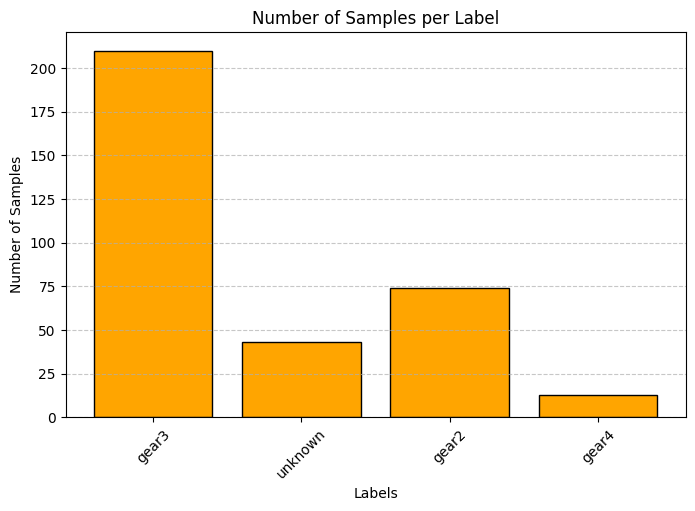

In [38]:
# Count occurrences of each label
label_counts = Counter(dataset.labels)
labels, values = zip(*label_counts.items())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='orange', edgecolor='black')

# Add labels and title
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Label")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [39]:
class Net(nn.Module):

    def __init__(self, input_channels, hidden1, hidden2, output):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(input_channels, hidden1)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.activation2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden2, output)

    def forward(self, input):
        out = self.activation(self.linear1(input))
        out = self.activation2(self.linear2(out))
        out = self.output_layer(out)
        
        return out 

In [40]:
input_channels = len(dataset[0][0]) # get first entry, then item and then first joint
hidden1 = input_channels*2
hidden2 = 64
output = len(set(dataset.labels))

net = Net(input_channels=input_channels, hidden1=hidden1, hidden2=hidden2, output=output)
net.to(device)

Net(
  (linear1): Linear(in_features=194, out_features=388, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=388, out_features=64, bias=True)
  (activation2): ReLU()
  (output_layer): Linear(in_features=64, out_features=4, bias=True)
)

## Training the Neural Net

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [42]:
train_losses, train_accs, train_precisions, train_recalls, train_f1s = [],[],[],[],[]
val_losses, val_accs, val_precisions, val_recalls, val_f1s = [],[],[],[],[]

best_val_acc = 0.0
best_val_loss = float('inf')
counter = 0

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print("Training")
    epoch_loss, epoch_acc, train_precision, train_recall, train_f1, train_conf_matrix = training(train_loader, net, criterion, optimizer, device)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_acc:.3f}")
    
    print("Validation")
    epoch_val_loss, epoch_val_acc, val_precision, val_recall, val_f1, val_conf_matrix = validation(val_loader, net, criterion, device)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_val_loss:.3f}, Accuracy: {epoch_val_acc:.3f}")

    # Check early stopping based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        # TODO Check more later if loss or any other metric
        current_time = datetime.now().strftime("%Y_%m_%d_%H_%M")  # Format as HH:MM:SS
        torch.save(net.state_dict(), f"best_model_{current_time}_lr{learning_rate}.pth")  # Save the best model
        print(f"Model saved at epoch {epoch+1}")
        counter = 0  # Reset patience counter
        best_val_cm = val_conf_matrix
        best_train_cm = train_conf_matrix
    else:
        counter += 1  # Increment counter if no loss improvement
    
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break  # Stop training
    
print('Finished Training')

Training
Epoch: 1/10, Loss: 0.738, Accuracy: 75.735
Validation
Epoch: 1/10, Loss: 0.573, Accuracy: 76.471
Model saved at epoch 1
Training
Epoch: 2/10, Loss: 0.241, Accuracy: 91.544
Validation
Epoch: 2/10, Loss: 0.462, Accuracy: 82.353
Model saved at epoch 2
Training
Epoch: 3/10, Loss: 0.147, Accuracy: 94.853
Validation
Epoch: 3/10, Loss: 0.471, Accuracy: 82.353
Training
Epoch: 4/10, Loss: 0.209, Accuracy: 94.853
Validation
Epoch: 4/10, Loss: 0.444, Accuracy: 82.353
Model saved at epoch 4
Training
Epoch: 5/10, Loss: 0.094, Accuracy: 96.691
Validation
Epoch: 5/10, Loss: 0.450, Accuracy: 85.294
Training
Epoch: 6/10, Loss: 0.086, Accuracy: 96.691
Validation
Epoch: 6/10, Loss: 0.389, Accuracy: 82.353
Model saved at epoch 6
Training
Epoch: 7/10, Loss: 0.048, Accuracy: 99.265
Validation
Epoch: 7/10, Loss: 0.477, Accuracy: 82.353
Training
Epoch: 8/10, Loss: 0.065, Accuracy: 97.794
Validation
Epoch: 8/10, Loss: 0.464, Accuracy: 79.412
Training
Epoch: 9/10, Loss: 0.046, Accuracy: 98.529
Validati

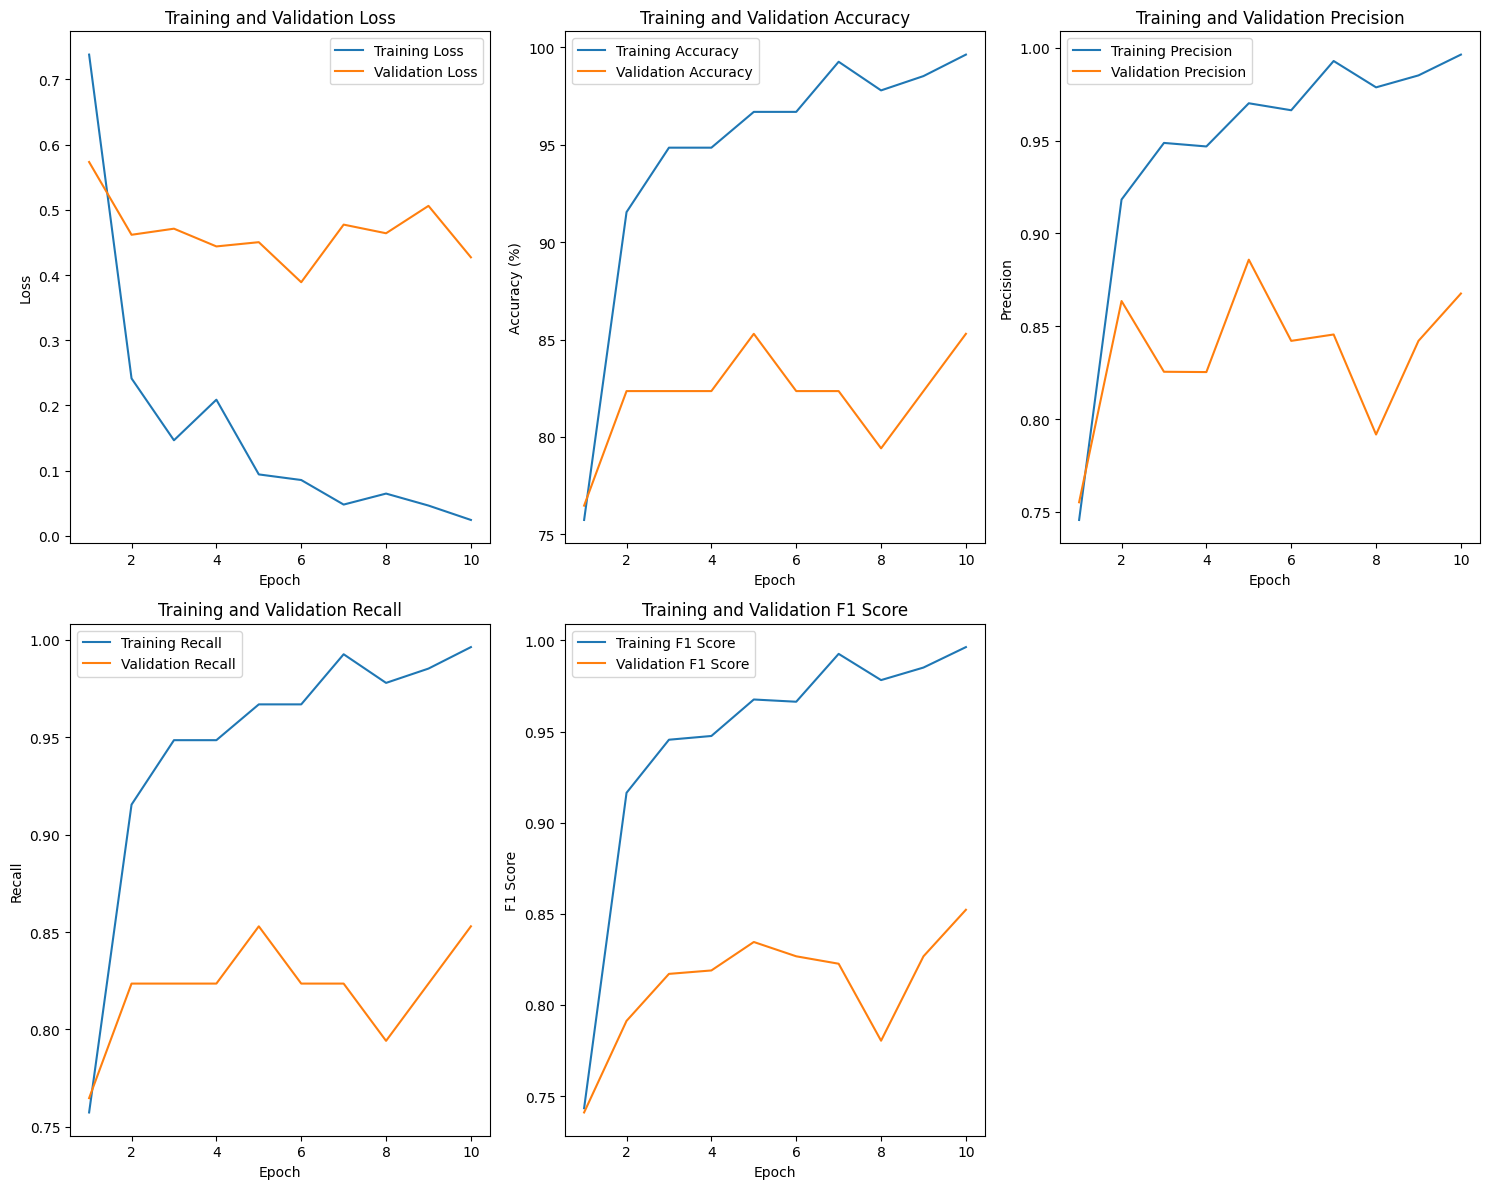

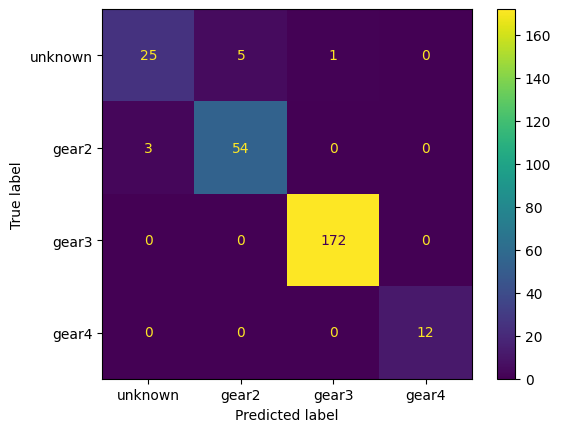

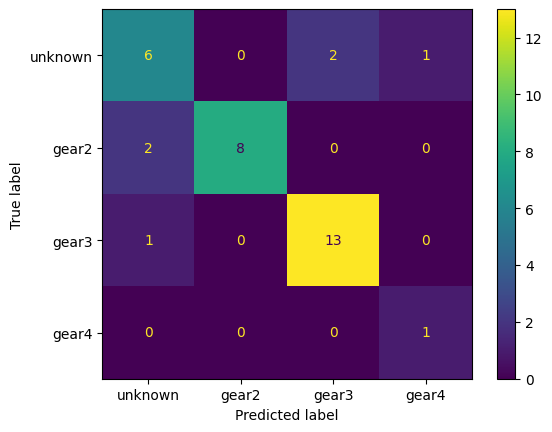

In [43]:
epochs_trained = len(train_losses)
epoch_range = range(1, epochs_trained + 1)

plt.figure(figsize=(15, 12))

# Plotting training and validation loss
plt.subplot(2, 3, 1)
plot_single_metric(epoch_range, train_losses, val_losses, 'Loss', 'Epoch', 'Loss')

# Plotting training and validation accuracy
plt.subplot(2, 3, 2)
plot_single_metric(epoch_range, train_accs, val_accs, 'Accuracy', 'Epoch', 'Accuracy (%)')

# Plotting training and validation precision
plt.subplot(2, 3, 3)
plot_single_metric(epoch_range, train_precisions, val_precisions, 'Precision', 'Epoch', 'Precision')

# Plotting training and validation recall
plt.subplot(2, 3, 4)
plot_single_metric(epoch_range, train_recalls, val_recalls, 'Recall', 'Epoch', 'Recall')

# Plotting training and validation F1 scores
plt.subplot(2, 3, 5)
plot_single_metric(epoch_range, train_f1s, val_f1s, 'F1 Score', 'Epoch', 'F1 Score')

plt.tight_layout()
plt.show()

disp_train_cm = ConfusionMatrixDisplay(best_train_cm, display_labels=list(LABELS.keys())[:len(set(dataset.labels))])
disp_train_cm.plot()
plt.show()
disp_val_cm = ConfusionMatrixDisplay(best_val_cm, display_labels=list(LABELS.keys())[:len(set(dataset.labels))])
disp_val_cm.plot()
plt.show()